In [504]:
import pymc3 as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix
from statsmodels.formula.api import ols, logit, glm

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

# Leinhard Dataset

In [41]:
leinh = pd.read_csv('Leinhardt.csv', index_col=[0])
leinh = leinh[~leinh.isna().any(1)]
leinh['log_income'] = np.log(leinh.income)
leinh['log_infant'] = np.log(leinh.infant)
leinh['oil'] = leinh.oil.apply(lambda x: 1 if x=='yes' else 0)

In [69]:
X = sm.add_constant(leinh[['log_income', 'oil']])
y = leinh.log_infant

with pm.Model() as model:
    sigma = pm.InverseGamma('sigma', alpha=5/2, beta=5*10/2)
    betas = []
    mu = 0
    for col_nm, feature in X.iteritems():
        beta = pm.Normal(col_nm, 0, sigma=1e6)
        betas.append(beta)
        mu += beta * feature
    
    nu = pm.Exponential('nu', 1)  # degree of freedom
    df = pm.Deterministic('ddf', nu + 2)  # min 2 or 2+

    y_hat = pm.StudentT('y_hat', mu=mu, sigma=sigma, nu=df, observed=y)

In [155]:
az.loo(bres, scale='deviance')

Computed from 40000 by 101 log-likelihood matrix

             Estimate       SE
deviance_loo   207.99    14.24
p_loo            3.09        -

In [70]:
with model:
    bres = pm.sample(draws=10000, chains=4, tune=5000, return_inferencedata=True)
    ppc = pm.sample_posterior_predictive(bres)

az.summary(bres)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, oil, log_income, const, sigma]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 36 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
const,7.337,0.327,6.710,7.939,0.003,0.002,16902.0,18483.0,1.0
log_income,-0.552,0.053,-0.648,-0.451,0.000,0.000,17046.0,19057.0,1.0
oil,0.342,0.326,-0.254,0.971,0.002,0.002,27042.0,22422.0,1.0
sigma,0.688,0.065,0.569,0.812,0.000,0.000,17127.0,10005.0,1.0
nu,3.003,1.538,0.490,5.860,0.010,0.007,20125.0,13837.0,1.0
ddf,5.003,1.538,2.490,7.860,0.010,0.007,20125.0,13837.0,1.0


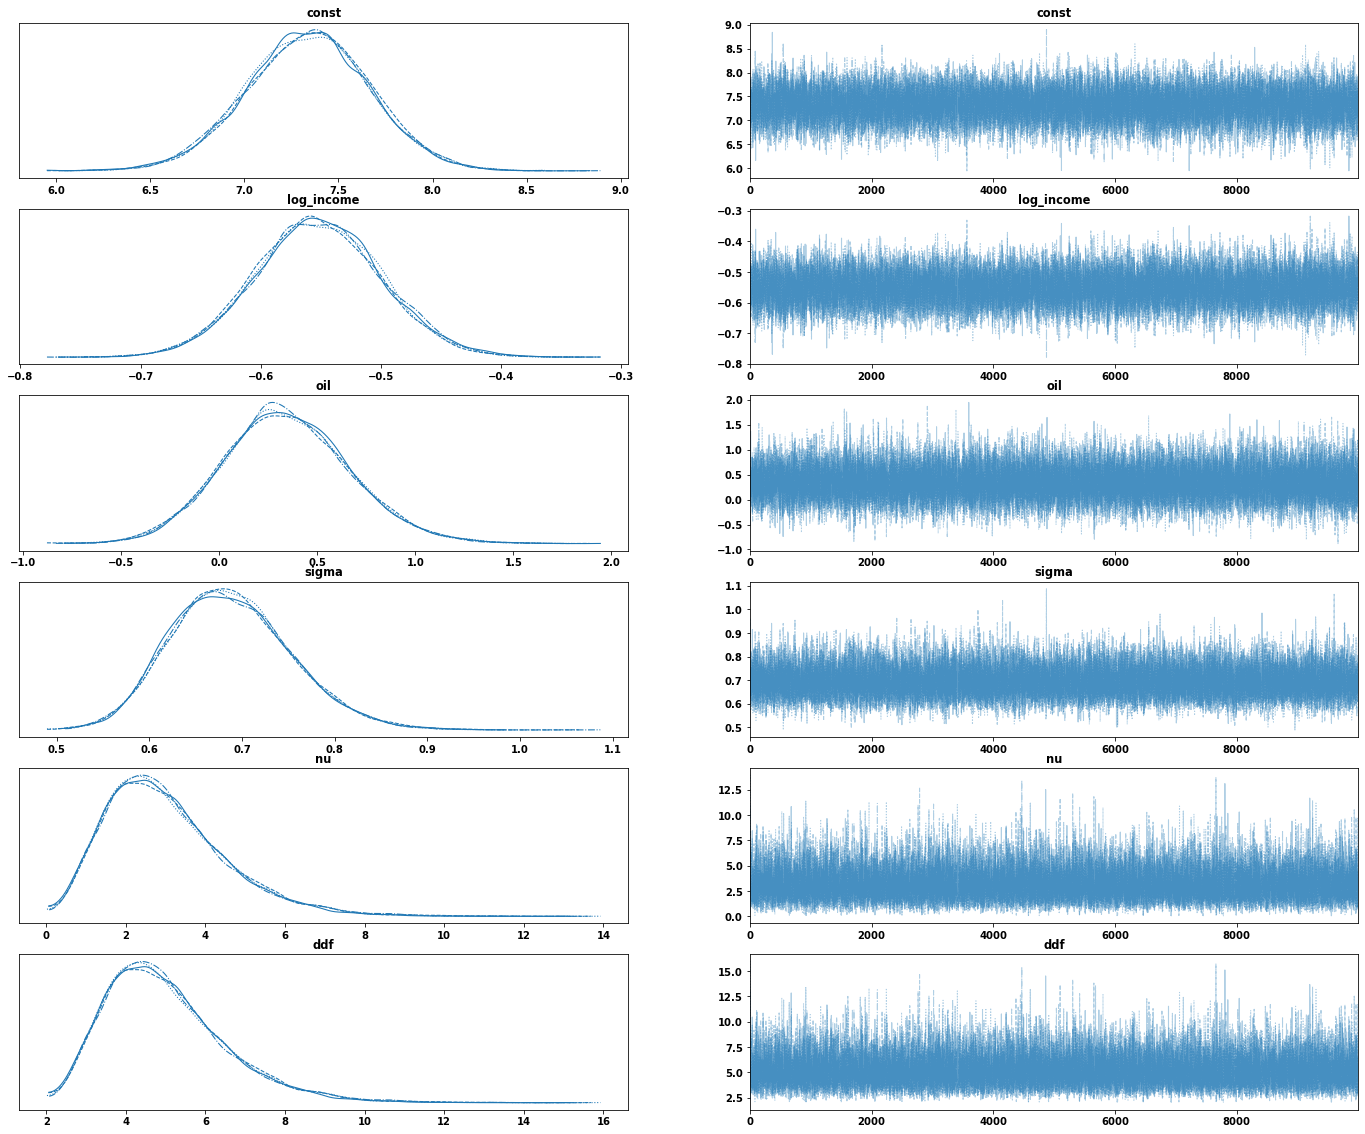

In [71]:
_ = az.plot_trace(bres, figsize=(24, 20))

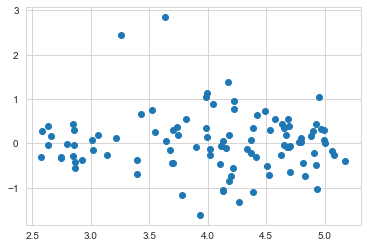

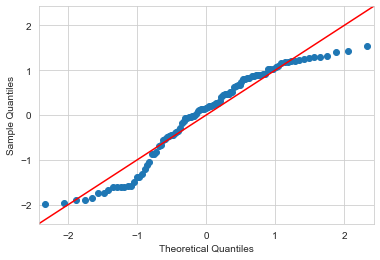

In [150]:
y_hat = (az.summary(bres)['mean'].drop('sigma') * X).sum(1)
resid = y - y_hat

_ = plt.scatter(y_hat, resid)
plt.show()

_ = sm.qqplot(y_hat, fit=True, line='45')
plt.show()

# PlantGrowth ANOVA

<AxesSubplot:xlabel='group', ylabel='weight'>

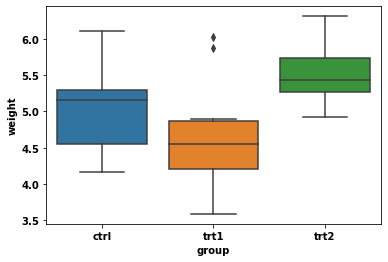

In [2]:
pg_data = sm.datasets.get_rdataset('PlantGrowth').data
sns.boxplot(data=pg_data, y='weight', x='group')

In [9]:
import bambi as bmb

model = bmb.Model('weight ~ -1 + C(group)', data=pg_data)
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_sigma, C(group)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [437]:
from statsmodels.formula.api import ols

res_ols = ols('weight ~ -1 + C(group)', data=pg_data).fit()
print(res_ols.summary())
print(sm.stats.anova_lm(res_ols, typ=2))

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Fri, 29 Oct 2021   Prob (F-statistic):             0.0159
Time:                        22:21:58   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
C(group)[ctrl]     5.0320      0.197     25.

In [441]:
X = pg_data[['group']]
X = pd.get_dummies(X, columns=['group'])
y = pg_data['weight']

with pm.Model() as model:
    betas = []
    mu = 0
    for col_nm, feature in X.iteritems():
        beta = pm.Normal(col_nm, 0, 100)
        betas.append(beta)
        mu += beta * feature
    
    sigma = pm.InverseGamma('sigma', alpha=5/2, beta=5/2)
    y_hat = pm.Normal('weight', mu, sigma, observed=y)

    step = pm.NUTS()
    res = pm.sample(5000, tune=1500, step=step, chains=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, group_trt2, group_trt1, group_ctrl]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 20 seconds.


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
group_ctrl  5.032  0.211     4.616      5.447      0.001    0.001   22352.0   
group_trt1  4.663  0.212     4.244      5.082      0.001    0.001   21708.0   
group_trt2  5.527  0.211     5.110      5.942      0.001    0.001   25466.0   
sigma       0.658  0.092     0.500      0.844      0.001    0.000   20490.0   

            ess_tail  r_hat  
group_ctrl   15016.0    1.0  
group_trt1   14350.0    1.0  
group_trt2   15268.0    1.0  
sigma        14206.0    1.0  


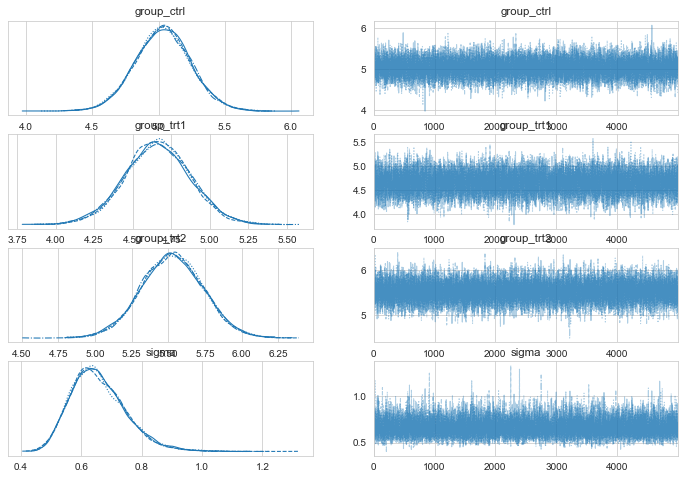

In [442]:
print(az.summary(res, hdi_prob=0.95))
_ = az.plot_trace(res)

In [436]:
pd.Series((res.posterior.group_trt2 - res.posterior.group_ctrl).to_numpy().ravel()).describe(percentiles=[0.025, 0.975])

count    20000.000000
mean         0.492390
std          0.300949
min         -0.770638
2.5%        -0.097824
50%          0.490955
97.5%        1.085128
max          1.631476
dtype: float64

In [352]:
X = pg_data[['group']]
X = pd.get_dummies(X, columns=['group'])
y = pg_data['weight']

with pm.Model() as model2:
    betas = []
    sigma = 0
    mu = 0
    for col_nm, feature in X.iteritems():
        beta = pm.Normal(col_nm, 0, 100)
        betas.append(beta)
        mu += beta * feature

        _sigma = pm.InverseGamma(col_nm+'_sigma', alpha=5/2, beta=5/2)
        sigma += _sigma * feature
    
    y_hat = pm.Normal('weight', mu, sigma, observed=y)

    step = pm.NUTS()
    res2 = pm.sample(5000, tune=1500, step=step, chains=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_trt2_sigma, group_trt2, group_trt1_sigma, group_trt1, group_ctrl_sigma, group_ctrl]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 21 seconds.


                   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
group_ctrl        5.030  0.225     4.599      5.489      0.002    0.001   
group_trt1        4.661  0.290     4.096      5.241      0.003    0.002   
group_trt2        5.526  0.182     5.163      5.886      0.001    0.001   
group_ctrl_sigma  0.687  0.175     0.408      1.034      0.002    0.001   
group_trt1_sigma  0.882  0.220     0.523      1.311      0.002    0.001   
group_trt2_sigma  0.557  0.145     0.320      0.837      0.001    0.001   

                  ess_bulk  ess_tail  r_hat  
group_ctrl         15183.0   11623.0    1.0  
group_trt1         12827.0   10131.0    1.0  
group_trt2         15558.0   12560.0    1.0  
group_ctrl_sigma   15595.0   11313.0    1.0  
group_trt1_sigma   14287.0   11943.0    1.0  
group_trt2_sigma   15584.0   12464.0    1.0  


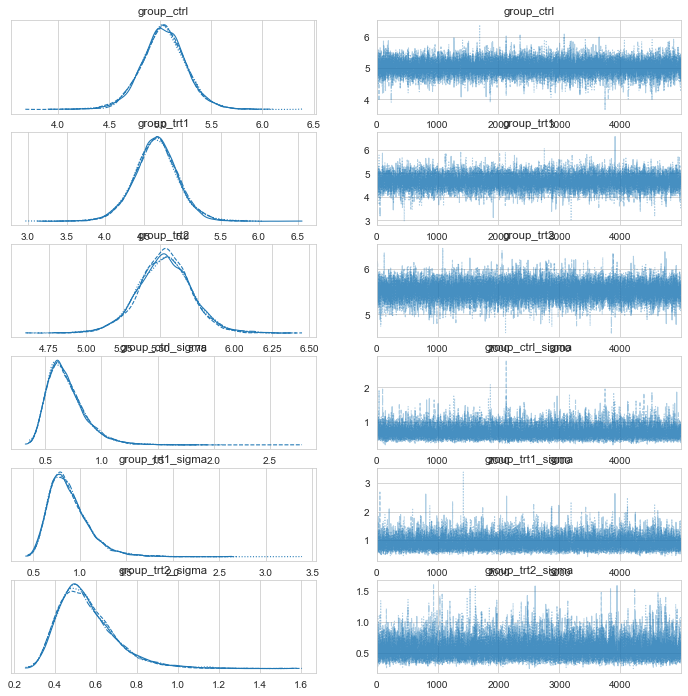

In [353]:
print(az.summary(res2, hdi_prob=0.95))
_ = az.plot_trace(res2)

In [451]:
print('Model 1\n', az.loo(res, scale='deviance'))
print('\nModel 2\n', az.loo(res2, scale='deviance'))

Model 1
 Computed from 20000 by 30 log-likelihood matrix

             Estimate       SE
deviance_loo    62.14     7.36
p_loo            3.58        -

Model 2
 Computed from 20000 by 30 log-likelihood matrix

             Estimate       SE
deviance_loo    62.26     6.23
p_loo            4.05        -


# Logistic - Urine Dataset from boot

In [2]:
boot_data = sm.datasets.get_rdataset('urine', 'boot').data
boot_data = boot_data[~boot_data.isna().any(1)]

In [3]:
X = boot_data.iloc[:, 1:]
X = (X - X.mean(0)) / X.std(0, ddof=1)
X = sm.add_constant(X)
y = boot_data['r']

In [4]:
with pm.Model() as model:
    betas = []
    lm_mu = 0
    for col_nm, feature in X.iteritems():
        if col_nm == 'const':
            beta = pm.Normal(col_nm, 0, 25)
        else:
            beta = pm.Laplace(col_nm, mu=0, b=np.sqrt(1/2))
        lm_mu += beta * feature

    p = pm.invlogit(lm_mu)
    # p = 1/(1+np.exp(-lm_mu))
    y_hat = pm.Bernoulli('r', p=p, observed=y)

    res = pm.sample(10000, tune=1000, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [calc, urea, cond, osmo, ph, gravity, const]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 31 seconds.


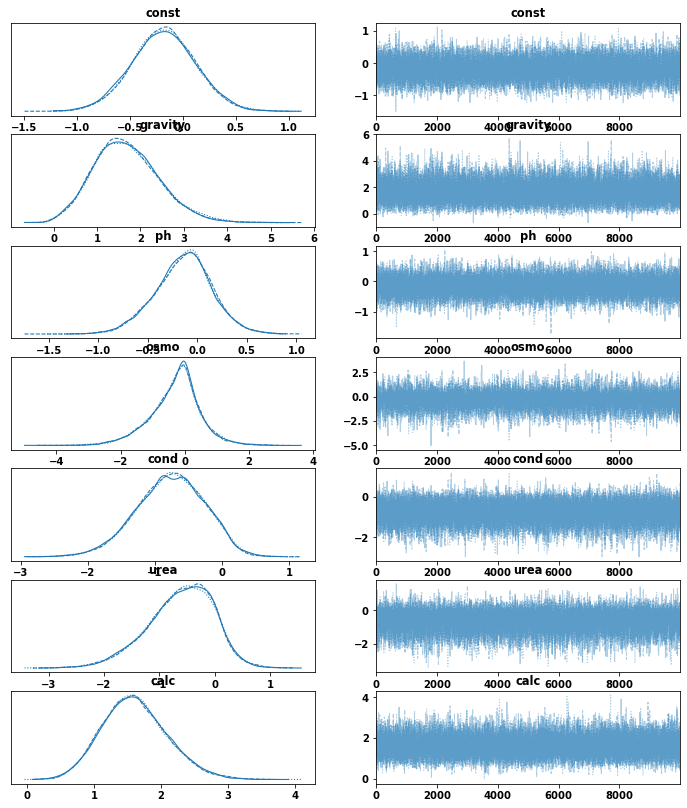

In [5]:
_ = az.plot_trace(res)

In [6]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
const,-0.179,0.301,-0.758,0.379,0.002,0.002,22060.0,19455.0,1.0
gravity,1.682,0.756,0.318,3.126,0.006,0.004,19208.0,16940.0,1.0
ph,-0.142,0.290,-0.711,0.391,0.002,0.002,24457.0,19556.0,1.0
osmo,-0.297,0.794,-1.957,1.131,0.007,0.006,15188.0,13728.0,1.0
cond,-0.768,0.506,-1.724,0.134,0.004,0.003,15597.0,17333.0,1.0
urea,-0.616,0.598,-1.840,0.362,0.005,0.004,16906.0,16555.0,1.0
calc,1.612,0.486,0.713,2.524,0.003,0.002,21620.0,18566.0,1.0


In [9]:
az.loo(res, scale='deviance')

Computed from 30000 by 77 log-likelihood matrix

             Estimate       SE
deviance_loo    73.62     8.80
p_loo            4.55        -

<AxesSubplot:xlabel='r'>

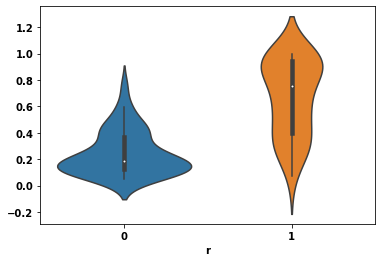

In [10]:
y_hat_prob = 1/(1+np.exp(-(res.posterior.mean().to_pandas() * X).sum(1)))
sns.violinplot(y=y_hat_prob, x=y)

AUC score 0.8842975206611571


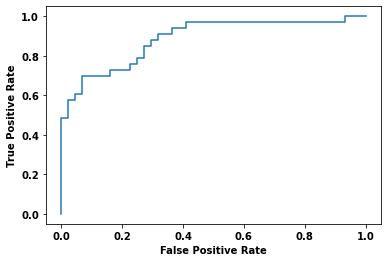

In [26]:
print('AUC score', roc_auc_score(y, y_hat_prob))
fpr, tpr, _ = roc_curve(y, y_hat_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Logistic - OME from MASS

In [269]:
ome_data = sm.datasets.get_rdataset('OME', 'MASS').data
ome_data = ome_data[~ome_data.isna().any(1)]
ome_data['cor_pct'] = ome_data['Correct'] / ome_data['Trials']

C:\Users\ztang\AppData\Local\Temp/ipykernel_11332/1265731417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ome_data['cor_pct'] = ome_data['Correct'] / ome_data['Trials']


In [416]:
mod_logit = glm(
        'cor_pct ~ Age + OME + Loud + Noise', data=ome_data,
        freq_weights=ome_data.Trials,
        family=sm.families.Binomial()
    ).fit()
print(mod_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                cor_pct   No. Observations:                  712
Model:                            GLM   Df Residuals:                     2846
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -888.08
Date:                Sat, 30 Oct 2021   Deviance:                       732.38
Time:                        20:24:13   Pearson chi2:                     795.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6252
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.2944    

In [474]:
X = ome_data[['Age', 'OME', 'Loud', 'Noise']]
X = pd.get_dummies(X, columns=['OME','Noise'], drop_first=True)
X = sm.add_constant(X)
n_trials = ome_data['Trials']
y_success = ome_data['Correct']

with pm.Model(coords=coords) as model:
    betas = []
    lm_mu = 0 
    for col_nm, feature in X.iteritems():
        beta = pm.Normal(col_nm, 0, 1e6)
        betas.append(beta)
        lm_mu += beta * feature
    
    p = pm.invlogit(lm_mu)
    y_hat = pm.Binomial('Correct', n=n_trials, p=p, observed=y_success)

    # print(pm.find_MAP())
    res = pm.sample(10000, tune=1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Noise_incoherent, OME_low, Loud, Age, const]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 134 seconds.


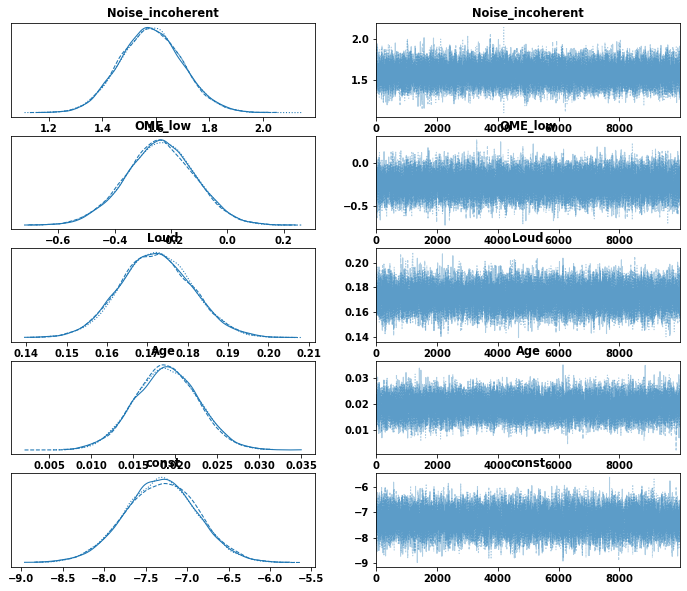

In [477]:
_ = az.plot_trace(res, var_names=['Noise_incoherent', 'OME_low', 'Loud', 'Age', 'const'])

In [480]:
az.summary(res, var_names=['Noise_incoherent', 'OME_low', 'Loud', 'Age', 'const'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Noise_incoherent,1.582,0.116,1.364,1.800,0.001,0.001,21712.0,18424.0,1.0
OME_low,-0.239,0.123,-0.474,-0.008,0.001,0.001,21606.0,18860.0,1.0
Loud,0.172,0.009,0.156,0.189,0.000,0.000,15715.0,16892.0,1.0
Age,0.019,0.004,0.012,0.026,0.000,0.000,18697.0,17446.0,1.0
const,-7.315,0.436,-8.164,-6.525,0.004,0.003,14131.0,15814.0,1.0


In [481]:
az.loo(res, scale='deviance')

Computed from 30000 by 712 log-likelihood matrix

             Estimate       SE
deviance_loo  1264.02    46.96
p_loo            6.25        -

Confusion Matrix
 [[182  63]
 [ 48 419]]
Accuracy 0.8441011235955056
AUC score 0.8200367084735394


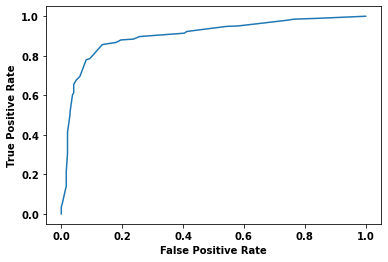

In [499]:
cutoff = 0.7

y_hat_prob = 1/(1 + np.exp(- (res.posterior.mean().to_pandas() * X).sum(1)))
# y_hat_prob = mod_logit.fittedvalues

res_df = pd.DataFrame(np.c_[y_success/n_trials, y_hat_prob], columns=['y', 'y_hat'])
res_df['pred'] = res_df.y_hat > cutoff
res_df['truth'] = res_df.y > cutoff


cma = confusion_matrix(res_df.truth, res_df.pred)
print('Confusion Matrix\n', cma)
print('Accuracy', np.diag(cma).sum() / cma.sum())

print('AUC score', roc_auc_score(res_df.truth, res_df.pred))
fpr, tpr, _ = roc_curve(res_df.truth, res_df.y_hat)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


# Warpbreak Dataset

In [508]:
wb_data = sm.datasets.get_rdataset('warpbreaks').data

In [514]:
wb_data.groupby(['wool', 'tension']).count().unstack()

breaks      
tension      H  L  M
wool                
A            9  9  9
B            9  9  9

<AxesSubplot:xlabel='tension', ylabel='breaks'>

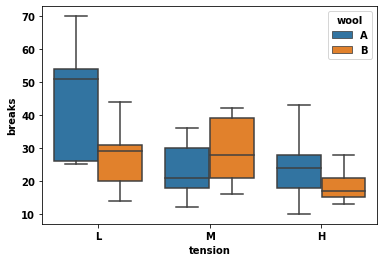

In [519]:
sns.boxplot(data=wb_data, x='tension', hue='wool', y='breaks')

In [576]:
X = pd.get_dummies(wb_data[['wool','tension']], columns=['wool','tension'])
X = X.drop(columns=['wool_A', 'tension_L'])
X = sm.add_constant(X)
X['wool_B:tesion_H'] = X.wool_B * X.tension_H
X['wool_B:tesion_M'] = X.wool_B * X.tension_M
y = np.log(wb_data.breaks)

with pm.Model() as model:
    betas = []
    mu = 0
    sigma = 0
    for col_nm, feature in X.iteritems():
        beta = pm.Normal(col_nm, 0, 1e6)
        betas.append(beta)
        mu += beta * feature
        sigma += pm.InverseGamma(f'sigma_{col_nm}', alpha=1/2, beta=1/2)
    
    y_hat = pm.Normal('breaks', mu=mu, sigma=sigma, observed=y)

    # print(pm.find_MAP())
    res = pm.sample(10000, tune=1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma_wool_B:tesion_M, wool_B:tesion_M, sigma_wool_B:tesion_H, wool_B:tesion_H, sigma_tension_M, tension_M, sigma_tension_H, tension_H, sigma_wool_B, wool_B, sigma_const, const]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 30 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6975338347948049, but should be close to 0.8. Try to increase the number of tuning steps.


In [577]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
const,3.719,0.207,3.315,4.092,0.002,0.001,11413.0,16263.0,1.0
wool_B,-0.437,0.294,-0.997,0.114,0.003,0.002,11442.0,16085.0,1.0
tension_H,-0.600,0.292,-1.169,-0.063,0.003,0.002,12685.0,16434.0,1.0
tension_M,-0.602,0.291,-1.127,-0.036,0.003,0.002,12955.0,16905.0,1.0
wool_B:tesion_H,0.223,0.415,-0.541,1.022,0.004,0.003,12745.0,16365.0,1.0
wool_B:tesion_M,0.630,0.415,-0.152,1.410,0.004,0.003,13198.0,17573.0,1.0
sigma_const,0.102,0.032,0.050,0.163,0.000,0.000,20184.0,15620.0,1.0
sigma_wool_B,0.102,0.032,0.048,0.162,0.000,0.000,21271.0,13809.0,1.0
sigma_tension_H,0.102,0.033,0.048,0.162,0.000,0.000,19760.0,14214.0,1.0
sigma_tension_M,0.102,0.033,0.048,0.164,0.000,0.000,18991.0,14010.0,1.0


In [536]:
# constant vairance only one group
az.loo(res, scale='deviance')

Computed from 30000 by 54 log-likelihood matrix

             Estimate       SE
deviance_loo    58.71     7.20
p_loo            3.01        -

In [554]:
# constant variance only two groups
az.loo(res, scale='deviance')

Computed from 30000 by 54 log-likelihood matrix

             Estimate       SE
deviance_loo    58.75     7.07
p_loo            3.78        -

In [561]:
# constant variances full groups with interaction
az.loo(res, scale='deviance')

Computed from 30000 by 54 log-likelihood matrix

             Estimate       SE
deviance_loo    56.34     6.41
p_loo            5.14        -

In [580]:
# different variances model full groups with interaction
az.loo(res, scale='deviance')

Computed from 30000 by 54 log-likelihood matrix

             Estimate       SE
deviance_loo    73.32     3.03
p_loo            2.90        -